# tRNet model building, training, and transfer learning

## Build simple model (housekeeping, inactive) using tuned hyperparameters, transfer to multi-label model, train with k-fold CV



## Install dependecies

In [9]:
!pip install tensorflow==1.15.5
!pip install keras==2.2.4

## Load dependencies

In [9]:
# Used additional packages
%matplotlib inline

import os
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# seeding random number generators
seed = 4
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

## Load data

For this we will use 200bp of sequence upstream of various tRNA genes. The positive set is Brf1 bound tRNAs in all cell types, and the negative set is never-bound tRNA upstream sequence

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   

In [3]:
# Load seq sets

def loadData(posSet_fasta, negSet_fasta):
    """Load data and output train and test set from fasta files of positive and negative upstream sequence
    
    Args:
    posSet_fasta: path to fasta file containing TF bound sequence of same lenght
    negSet_fasta: path to fasta file containing unbound sequence
    """
    posSet_seq = []
    # Convert fasta files to 1-hot encoded arrays
    # Generate y arrays (just "True" * num_seqs, same but "False" for negative set)
    with open(posSet_fasta, "r") as seqs:
        for line in seqs:
            if not line.startswith(">"):
                seq = line.strip().upper()
                posSet_seq.append(seq)
                
    posSet_1hot = []
    
    one_hot_encoder = OneHotEncoder(categories='auto')
    for sequence in posSet_seq:
        integer_encoded = integer_encoder.fit_transform(list(sequence))
        integer_encoded = np.array(integer_encoded).reshape(-1, 1)
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
        posSet_1hot.append(one_hot_encoded.toarray())
    
    posSet_y = np.array([1] * len(posSet_1hot))
    
    negSet_seq = []
    with open(negSet_fasta, "r") as seqs:
        for line in seqs:
            if not line.startswith(">"):
                seq = line.strip().upper()
                negSet_seq.append(seq)
                
    negSet_1hot = []
    
    one_hot_encoder = OneHotEncoder(categories='auto')
    for sequence in negSet_seq:
        integer_encoded = integer_encoder.fit_transform(list(sequence))
        integer_encoded = np.array(integer_encoded).reshape(-1, 1)
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
        negSet_1hot.append(one_hot_encoded.toarray())
    
    negSet_y = np.array([0] * len(negSet_1hot))
    
    #one_hot_encoder = OneHotEncoder(categories='auto')
    #labels = np.array(y).reshape(-1, 1)
    #y_1hot = one_hot_encoder.fit_transform(labels).toarray()
    
    # Combine pos and neg X and y data
    
    X = np.concatenate((posSet_1hot, negSet_1hot))
    y = np.concatenate((posSet_y, negSet_y))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25)
    
    return (X_train, y_train), (X_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = loadData("data/hg38-tRNAs-multiFiltered_upstream200_housekeeping.fa", "data/hg38-tRNAs-multiFiltered_upstream200_inactive.fa")

In [5]:
x_train.shape

(308, 200, 4)

## Define convolutional neural network, train and test

In [6]:
## required keras modules
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential, model_from_json
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
from tensorflow.keras.callbacks import EarlyStopping, History


In [7]:
# check keras version: please make sure this is `2.2.4-tf`
keras.__version__

'2.2.4-tf'

In [8]:
# check tensorflow version: please make sure this is `1.15.5`
tf.__version__

'1.15.5'

In [9]:
def tRNet_model():
    
    inputs = kl.Input((200, 4))
    
    x = kl.Conv1D(128, kernel_size=20, padding='same', activation = "relu")(inputs)
    
    for i in range(1,8):
        conv_x = kl.Conv1D(128, kernel_size=10, padding='same', dilation_rate = 2**i, activation="relu")(x)
        x = kl.add([conv_x, x])
    
    # These two lines are the same as GlobalMaxPool1D except this avoids the error of inconsistent tensor shapes
    # when extracting contribution scores with SHAP (Brf1CNN_SHAP_TFMoDISco.ipynb)
    # see https://github.com/slundberg/shap/issues/559
    max_pool1 = kl.MaxPooling1D(pool_size=200, strides=1)(x)
    max_pool1 = kl.Lambda(lambda s: keras.backend.squeeze(s, axis=1))(max_pool1)
    #x = kl.GlobalMaxPool1D()(x)
    
    x = kl.Dense(32)(max_pool1)
        
    outputs = kl.Dense(1)(x)
    outputs = kl.Activation('sigmoid')(outputs)

    model = Model(inputs = inputs, outputs = outputs)

    return model

In [10]:
model = tRNet_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 128)     10368       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     163968      conv1d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 200, 128)     0           conv1d_1[0][0]                   
             

In [11]:
def get_model_name(k):
    # to save best model for each fold
    return 'model_'+str(k)+'.h5'

In [12]:
# set k-folds
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5) 

In [13]:
# history plot functions
import matplotlib.pyplot as plt
def plot_loss(history):
    fig, ax = plt.subplots(figsize = (5,5))
    ax.plot(history['loss'][1:])
    ax.plot(history['val_loss'][1:])
    plt.xlabel('epoch')
    plt.ylabel('Binary crossentropy')
    
def plot_acc(history):
    fig, ax = plt.subplots(figsize = (5,5))
    ax.plot(history['acc'][1:])
    ax.plot(history['val_acc'][1:])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 246 samples, validate on 62 samples
Epoch 1/300
224/246 [==========================>...] - ETA: 0s - loss: 0.8589 - acc: 0.5580
Epoch 00001: val_loss improved from inf to 0.69829, saving model to ./kFoldCV_saved_models/model_1.h5
246/246 [==============================] - 2s 8ms/sample - loss: 0.8451 - acc: 0.5528 - val_loss: 0.6983 - val_acc: 0.5645
Epoch 2/300
224/246 [==========================>...] - ETA: 0s - loss: 0.6712 - acc: 0.5491
Epoch 00002: val_loss improved from 0.69829 to 0.67173, saving model to ./kFoldCV_saved_models/model_1.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.6659 - acc: 0.5610 - val_loss: 0.6717 - val_acc: 0.6774
Epoch 3/300
224/246 [==========================>...] - ETA: 0s - loss: 0.5882 - acc: 0.9509
Epoch 00003: val_loss improved from 0.67173 to 0.66396, saving model to ./kFoldCV_saved_models/model_1.h5
246/246 [================

Epoch 7/300
224/246 [==========================>...] - ETA: 0s - loss: 0.3485 - acc: 0.9911
Epoch 00007: val_loss did not improve from 0.64147
246/246 [==============================] - 1s 6ms/sample - loss: 0.3510 - acc: 0.9837 - val_loss: 0.6502 - val_acc: 0.5645
Epoch 8/300
224/246 [==========================>...] - ETA: 0s - loss: 0.3029 - acc: 1.0000
Epoch 00008: val_loss improved from 0.64147 to 0.62024, saving model to ./kFoldCV_saved_models/model_2.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.3039 - acc: 1.0000 - val_loss: 0.6202 - val_acc: 0.6613
Epoch 9/300
224/246 [==========================>...] - ETA: 0s - loss: 0.2571 - acc: 0.9955
Epoch 00009: val_loss did not improve from 0.62024
246/246 [==============================] - 1s 6ms/sample - loss: 0.2574 - acc: 0.9959 - val_loss: 0.6274 - val_acc: 0.6774
Epoch 10/300
224/246 [==========================>...] - ETA: 0s - loss: 0.2247 - acc: 1.0000
Epoch 00010: val_loss did not improve from 0.62024
246

Epoch 4/300
224/246 [==========================>...] - ETA: 0s - loss: 0.4979 - acc: 0.9018
Epoch 00004: val_loss improved from 0.67254 to 0.66421, saving model to ./kFoldCV_saved_models/model_3.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.4903 - acc: 0.8984 - val_loss: 0.6642 - val_acc: 0.5645
Epoch 5/300
224/246 [==========================>...] - ETA: 0s - loss: 0.4218 - acc: 0.9911
Epoch 00005: val_loss improved from 0.66421 to 0.64417, saving model to ./kFoldCV_saved_models/model_3.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.4198 - acc: 0.9919 - val_loss: 0.6442 - val_acc: 0.6452
Epoch 6/300
224/246 [==========================>...] - ETA: 0s - loss: 0.3657 - acc: 0.9911
Epoch 00006: val_loss improved from 0.64417 to 0.63517, saving model to ./kFoldCV_saved_models/model_3.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.3670 - acc: 0.9878 - val_loss: 0.6352 - val_acc: 0.7419
Epoch 7/300
224/246 [================

Epoch 32/300
224/246 [==========================>...] - ETA: 0s - loss: 0.0097 - acc: 1.0000
Epoch 00032: val_loss improved from 0.51472 to 0.51440, saving model to ./kFoldCV_saved_models/model_3.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.0097 - acc: 1.0000 - val_loss: 0.5144 - val_acc: 0.7097
Epoch 33/300
224/246 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 1.0000
Epoch 00033: val_loss did not improve from 0.51440
246/246 [==============================] - 1s 5ms/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 0.5483 - val_acc: 0.7097
Epoch 34/300
224/246 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 1.0000
Epoch 00034: val_loss improved from 0.51440 to 0.50627, saving model to ./kFoldCV_saved_models/model_3.h5
246/246 [==============================] - 1s 6ms/sample - loss: 0.0087 - acc: 1.0000 - val_loss: 0.5063 - val_acc: 0.7097
Epoch 35/300
224/246 [==========================>...] - ETA: 0s - loss: 0.0080 - acc: 1.0

Epoch 6/300
224/247 [==========================>...] - ETA: 0s - loss: 0.3653 - acc: 0.9777
Epoch 00006: val_loss improved from 0.61502 to 0.59737, saving model to ./kFoldCV_saved_models/model_5.h5
247/247 [==============================] - 1s 6ms/sample - loss: 0.3605 - acc: 0.9798 - val_loss: 0.5974 - val_acc: 0.8033
Epoch 7/300
224/247 [==========================>...] - ETA: 0s - loss: 0.2966 - acc: 1.0000
Epoch 00007: val_loss improved from 0.59737 to 0.57988, saving model to ./kFoldCV_saved_models/model_5.h5
247/247 [==============================] - 1s 6ms/sample - loss: 0.2959 - acc: 1.0000 - val_loss: 0.5799 - val_acc: 0.7377
Epoch 8/300
224/247 [==========================>...] - ETA: 0s - loss: 0.2586 - acc: 1.0000
Epoch 00008: val_loss did not improve from 0.57988
247/247 [==============================] - 1s 5ms/sample - loss: 0.2577 - acc: 1.0000 - val_loss: 0.6067 - val_acc: 0.6393
Epoch 9/300
224/247 [==========================>...] - ETA: 0s - loss: 0.2323 - acc: 1.0000


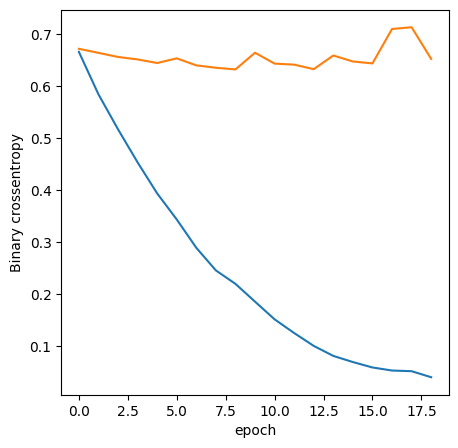

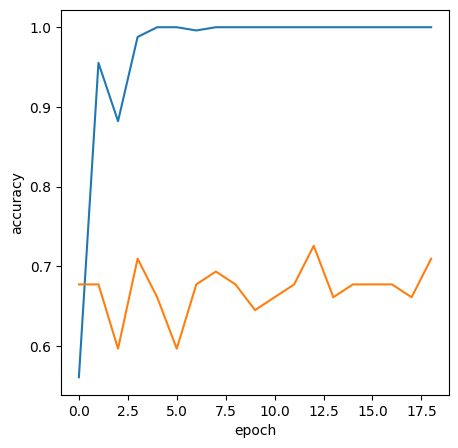

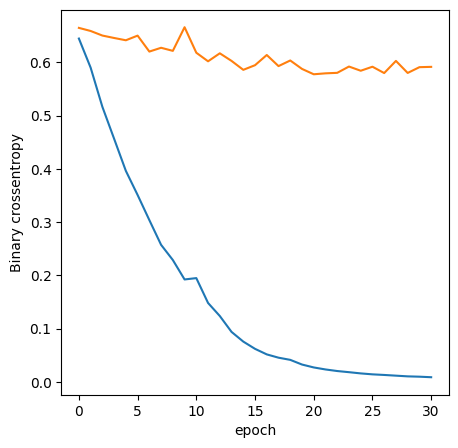

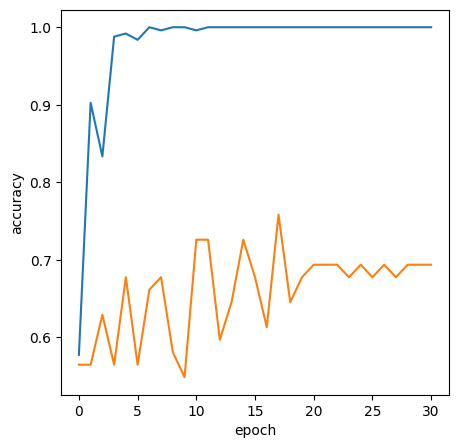

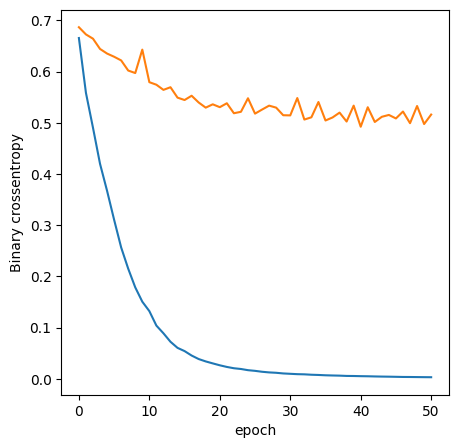

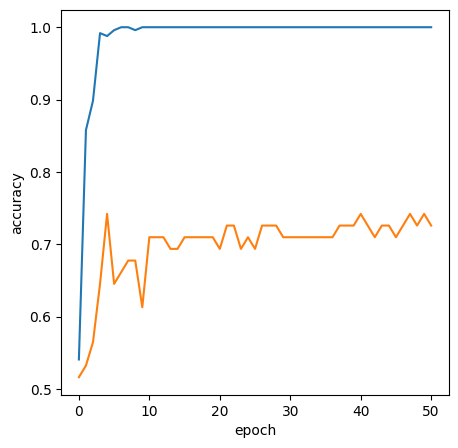

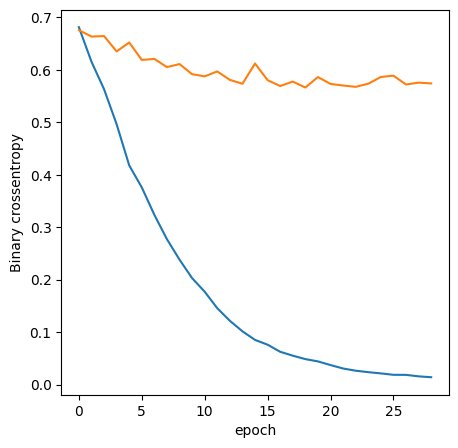

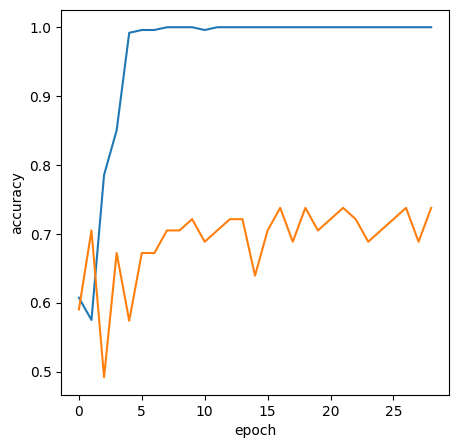

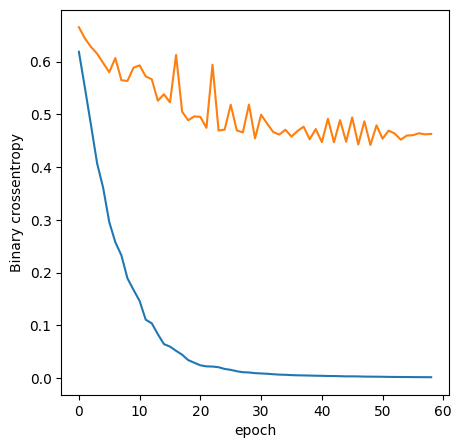

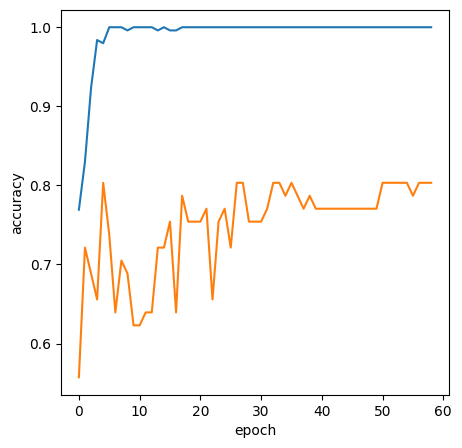

In [14]:
## Training

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = './kFoldCV_saved_models/'
if not os.path.isdir(save_dir):
    !mkdir kFoldCV_saved_models
fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(x_train)),y_train):
    training_data_x = x_train[train_index]
    training_data_y = y_train[train_index]
    validation_data_x = x_train[val_index]
    validation_data_y = y_train[val_index]
    
    # CREATE NEW MODEL
    model_single = tRNet_model()
    # COMPILE NEW MODEL
    # learning rate from above tuner results
    model_single.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00025026247369061555),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_loss', verbose=1, 
                                                    save_best_only=True, mode='min')
    
    callbacks_list = [checkpoint,
                      EarlyStopping(patience=10, restore_best_weights=True),
                      History()]

    # Train the model
    history_transfer = model_single.fit(training_data_x,
                                 training_data_y,
                                 validation_data=(validation_data_x, validation_data_y),
                                 callbacks=callbacks_list,
                                 epochs=300) 
    
    # plot history
    plot_loss(history_transfer.history)
    plot_acc(history_transfer.history)
    
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model_single.load_weights(save_dir+get_model_name(fold_var))

    results = model_single.evaluate(validation_data_x, validation_data_y)
    results = dict(zip(model_single.metrics_names,results))

    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()

    fold_var += 1

In [15]:
# Check accuracy of all 5 folds
VALIDATION_ACCURACY

[0.67741936, 0.6935484, 0.7419355, 0.73770493, 0.7704918]

In [16]:
# Check loss
VALIDATION_LOSS

[0.6321473237006895,
 0.5776197141216647,
 0.49224376197784175,
 0.5661187191478542,
 0.44190135011907483]

In [17]:
# load best performing model
best_index = VALIDATION_LOSS.index(min(VALIDATION_LOSS)) + 1
print("K-fold with lowest loss: {}".format(best_index))
best_model = keras.models.load_model(save_dir + "model_" + str(best_index) + ".h5")

K-fold with lowest loss: 5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
# Evaluate the best model on held out data
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

78/78 [==============================] - 0s 3ms/sample - loss: 0.5198 - acc: 0.7179
[test loss, test accuracy]: [0.5198256426896805, 0.71794873]


In [19]:
# AUROC performance

from sklearn.metrics import roc_curve, roc_auc_score

roc = {}
fpr = {}
tpr = {}

y_test_pred = best_model.predict(x_test)

roc['Brf1_tuner'] = roc_auc_score(y_test, y_test_pred)

In [20]:
roc['Brf1_tuner'] 

0.8200395517468688

In [21]:
fpr['Brf1_tuner'], tpr["Brf1_tuner"], _ = roc_curve(y_test, y_test_pred)

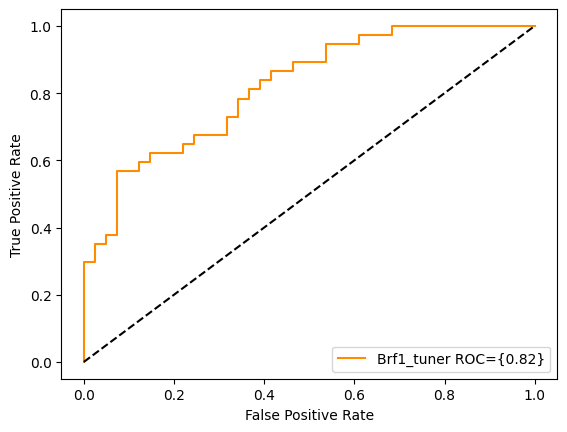

In [22]:
# plot ROC
plt.plot(fpr['Brf1_tuner'], tpr["Brf1_tuner"], color='darkorange', 
        label = 'Brf1_tuner ROC={%0.2f}' % roc['Brf1_tuner'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [23]:
# save weights to HDF5
if not os.path.isdir("model"):
    !mkdir model
best_model.save_weights("model/tRNet_binary_modelWeights.h5")
# save architecture to json
model_json = best_model.to_json()
with open("model/tRNet_binary_modelJSON.json", "w") as json_file:
    json_file.write(model_json)
    
# save whole model
best_model.save("model/tRNet_binary_model.h5")

## Transfer to multi-label model and retrain with CV

## Load data

For this we will use 200bp of sequence upstream of all tRNA genes. The associated labels will be a one-hot matrix of width 4, to indicate the group each tRNA belongs to, which is one of:
* Housekeeping tRNA
* Repressed occupancy across differentiation
* Persistently inactive

In [5]:
from collections import defaultdict

In [6]:
tasks = ['housekeeping', 'restricted', 'off']

In [11]:
# Load seq sets

def loadData(housekeeping, restricted, off):
    """Load data and output train and test set from fasta files of upstream sequence of different groups of tRNAs
    
    Args:
    housekeeping: fasta of 200bp upstream seq of housekeeping tRNAs
    restricted: fasta of restricted/regulated tRNAs across diff.
    iPSC: fasta of iPSC only tRNAs
    off: fasta of persistently off tRNAs
    """
    
    # Convert fasta files to 1-hot encoded arrays
    # Generate y arrays (1-hot matrix for 4 tasks)
    
    seqSet_1hot = []
    seqSet_y = []
    for i, task in enumerate([housekeeping, restricted, off]):
        default_y = [0,0,0]
        seqSet = []
        with open(task, "r") as seqs:
            for line in seqs:
                if not line.startswith(">"):
                    seq = line.strip().upper()
                    seqSet.append(seq)
    
        one_hot_encoder = OneHotEncoder(categories='auto')
        for sequence in seqSet:
            integer_encoded = integer_encoder.fit_transform(list(sequence))
            integer_encoded = np.array(integer_encoded).reshape(-1, 1)
            one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
            seqSet_1hot.append(one_hot_encoded.toarray())
        
        default_y[i] = 1
        y_set = np.array([default_y] * len(seqSet))
        seqSet_y.append(y_set)
        # Combine pos and neg X and y data
    
    X = np.array(seqSet_1hot)
    y = np.concatenate(seqSet_y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25)
    
    return (X_train, y_train), (X_test, y_test)

In [12]:
(x_train, y_train), (x_test, y_test) = loadData("data/hg38-tRNAs-multiFiltered_upstream200_housekeeping.fa", "data/hg38-tRNAs-multiFiltered_upstream200_repressed.fa", "data/hg38-tRNAs-multiFiltered_upstream200_inactive.fa")

In [28]:
# best model from above binary model training
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 128)     10368       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     163968      conv1d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 200, 128)     0           conv1d_1[0][0]                   
                                                                 conv1d[0][0]                 

In [29]:
## Create a new model by using part of the model constructed previously. 
## Keep all layers but the last two fully connected layers. 

transferred_model = Model(best_model.inputs, best_model.layers[-4].output)

transferred_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 128)     10368       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     163968      conv1d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 200, 128)     0           conv1d_1[0][0]                   
                                                                 conv1d[0][0]                 

In [30]:
# It is important to freeze the parameters of the transferred layers so their weights don't get drastically changed 
# in the first iterations of training, therefore loosing what was learned. 
# Set the trainable attribute of each layer to False.

for layer in transferred_model.layers:
    layer.trainable = False

In [31]:
def get_model():
    ## Create the multi-task model by using the transferred layers plus extra layers for the prediction on each task
    ## using a softmax acitvated fully connected layer with 3 outputs; one for each task
    # updated code to create flattened model instead of nested functional model
    inputs = kl.Input((200,4), name = 'input_main')

    #new_model = Model(inputs=inputs, outputs=transferred_model.call(inputs))

    x = transferred_model.call([inputs])

    x = kl.Dense(32)(x)

    x = kl.Dense(units=len(tasks))(x)
    
    output = kl.Activation('softmax')(x)

    mt_model_transfer = Model(inputs=inputs, outputs=output)
    return(mt_model_transfer)

Train on 356 samples, validate on 90 samples
Epoch 1/300
352/356 [============================>.] - ETA: 0s - loss: 2.9826 - acc: 0.4915
Epoch 00001: val_loss improved from inf to 1.53309, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 4ms/sample - loss: 2.9739 - acc: 0.4916 - val_loss: 1.5331 - val_acc: 0.4000
Epoch 2/300
352/356 [============================>.] - ETA: 0s - loss: 1.1685 - acc: 0.4347
Epoch 00002: val_loss improved from 1.53309 to 1.17994, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 1.1715 - acc: 0.4326 - val_loss: 1.1799 - val_acc: 0.3333
Epoch 3/300
352/356 [============================>.] - ETA: 0s - loss: 1.1028 - acc: 0.4517
Epoch 00003: val_loss improved from 1.17994 to 1.13027, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 1.0984 - acc: 0.4551 - val_loss: 1.1303 - val_acc: 0.4

Epoch 28/300
352/356 [============================>.] - ETA: 0s - loss: 0.7393 - acc: 0.6705
Epoch 00028: val_loss improved from 0.85880 to 0.84865, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 0.7411 - acc: 0.6713 - val_loss: 0.8487 - val_acc: 0.5778
Epoch 29/300
352/356 [============================>.] - ETA: 0s - loss: 0.7578 - acc: 0.6250
Epoch 00029: val_loss did not improve from 0.84865
356/356 [==============================] - 1s 3ms/sample - loss: 0.7587 - acc: 0.6236 - val_loss: 0.8766 - val_acc: 0.5222
Epoch 30/300
352/356 [============================>.] - ETA: 0s - loss: 0.7334 - acc: 0.6989
Epoch 00030: val_loss did not improve from 0.84865
356/356 [==============================] - 1s 3ms/sample - loss: 0.7344 - acc: 0.6966 - val_loss: 0.8539 - val_acc: 0.5667
Epoch 31/300
352/356 [============================>.] - ETA: 0s - loss: 0.7200 - acc: 0.7045
Epoch 00031: val_loss improved from 0.84865 to 0.83

Epoch 56/300
352/356 [============================>.] - ETA: 0s - loss: 0.6327 - acc: 0.7159
Epoch 00056: val_loss did not improve from 0.75174
356/356 [==============================] - 1s 3ms/sample - loss: 0.6289 - acc: 0.7191 - val_loss: 0.7519 - val_acc: 0.6000
Epoch 57/300
352/356 [============================>.] - ETA: 0s - loss: 0.6232 - acc: 0.7585
Epoch 00057: val_loss did not improve from 0.75174
356/356 [==============================] - 1s 3ms/sample - loss: 0.6211 - acc: 0.7612 - val_loss: 0.8001 - val_acc: 0.5778
Epoch 58/300
352/356 [============================>.] - ETA: 0s - loss: 0.6244 - acc: 0.7188
Epoch 00058: val_loss improved from 0.75174 to 0.74805, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 0.6236 - acc: 0.7191 - val_loss: 0.7481 - val_acc: 0.6778
Epoch 59/300
352/356 [============================>.] - ETA: 0s - loss: 0.6214 - acc: 0.7074
Epoch 00059: val_loss did not improve from 0.74805


Epoch 85/300
352/356 [============================>.] - ETA: 0s - loss: 0.5613 - acc: 0.7415
Epoch 00085: val_loss improved from 0.71274 to 0.70812, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 0.5655 - acc: 0.7416 - val_loss: 0.7081 - val_acc: 0.6111
Epoch 86/300
352/356 [============================>.] - ETA: 0s - loss: 0.5529 - acc: 0.7699
Epoch 00086: val_loss did not improve from 0.70812
356/356 [==============================] - 1s 3ms/sample - loss: 0.5507 - acc: 0.7697 - val_loss: 0.7220 - val_acc: 0.6111
Epoch 87/300
352/356 [============================>.] - ETA: 0s - loss: 0.5556 - acc: 0.7415
Epoch 00087: val_loss improved from 0.70812 to 0.70520, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 0.5535 - acc: 0.7444 - val_loss: 0.7052 - val_acc: 0.6667
Epoch 88/300
352/356 [============================>.] - ETA: 0s - loss: 0.5506 - acc: 0.7

Epoch 114/300
352/356 [============================>.] - ETA: 0s - loss: 0.5147 - acc: 0.7841
Epoch 00114: val_loss improved from 0.68956 to 0.68850, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 1s 3ms/sample - loss: 0.5149 - acc: 0.7837 - val_loss: 0.6885 - val_acc: 0.6444
Epoch 115/300
352/356 [============================>.] - ETA: 0s - loss: 0.5377 - acc: 0.7642
Epoch 00115: val_loss did not improve from 0.68850
356/356 [==============================] - 1s 3ms/sample - loss: 0.5358 - acc: 0.7669 - val_loss: 0.7000 - val_acc: 0.6222
Epoch 116/300
352/356 [============================>.] - ETA: 0s - loss: 0.5156 - acc: 0.7812
Epoch 00116: val_loss did not improve from 0.68850
356/356 [==============================] - 1s 3ms/sample - loss: 0.5150 - acc: 0.7809 - val_loss: 0.6941 - val_acc: 0.6444
Epoch 117/300
352/356 [============================>.] - ETA: 0s - loss: 0.5182 - acc: 0.7869
Epoch 00117: val_loss did not improve from 0.68

Epoch 143/300
352/356 [============================>.] - ETA: 0s - loss: 0.5244 - acc: 0.7670
Epoch 00143: val_loss did not improve from 0.68186
356/356 [==============================] - 1s 3ms/sample - loss: 0.5231 - acc: 0.7697 - val_loss: 0.6928 - val_acc: 0.6444
Epoch 144/300
352/356 [============================>.] - ETA: 0s - loss: 0.5039 - acc: 0.7699
Epoch 00144: val_loss did not improve from 0.68186
356/356 [==============================] - 1s 3ms/sample - loss: 0.4988 - acc: 0.7725 - val_loss: 0.6900 - val_acc: 0.6222
Epoch 145/300
352/356 [============================>.] - ETA: 0s - loss: 0.5004 - acc: 0.7784
Epoch 00145: val_loss did not improve from 0.68186
356/356 [==============================] - 1s 3ms/sample - loss: 0.4960 - acc: 0.7809 - val_loss: 0.6845 - val_acc: 0.6889
Epoch 146/300
320/356 [=========================>....] - ETA: 0s - loss: 0.5016 - acc: 0.7688
Epoch 00146: val_loss improved from 0.68186 to 0.68183, saving model to ./kFoldCV_saved_models/model_1

352/357 [============================>.] - ETA: 0s - loss: 0.8079 - acc: 0.6477
Epoch 00039: val_loss improved from 0.72019 to 0.71439, saving model to ./kFoldCV_saved_models/model_2.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.8040 - acc: 0.6499 - val_loss: 0.7144 - val_acc: 0.6966
Epoch 40/300
352/357 [============================>.] - ETA: 0s - loss: 0.8183 - acc: 0.6136
Epoch 00040: val_loss did not improve from 0.71439
357/357 [==============================] - 1s 3ms/sample - loss: 0.8176 - acc: 0.6134 - val_loss: 0.7766 - val_acc: 0.6629
Epoch 41/300
352/357 [============================>.] - ETA: 0s - loss: 0.8047 - acc: 0.6420
Epoch 00041: val_loss improved from 0.71439 to 0.70894, saving model to ./kFoldCV_saved_models/model_2.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.8048 - acc: 0.6415 - val_loss: 0.7089 - val_acc: 0.6742
Epoch 42/300
352/357 [============================>.] - ETA: 0s - loss: 0.7819 - acc: 0.6250
Epoch 000

Epoch 96/300
352/357 [============================>.] - ETA: 0s - loss: 0.6264 - acc: 0.7074
Epoch 00096: val_loss did not improve from 0.54684
357/357 [==============================] - 1s 3ms/sample - loss: 0.6250 - acc: 0.7087 - val_loss: 0.5815 - val_acc: 0.7978
Epoch 97/300
352/357 [============================>.] - ETA: 0s - loss: 0.6371 - acc: 0.7017
Epoch 00097: val_loss did not improve from 0.54684
357/357 [==============================] - 1s 3ms/sample - loss: 0.6363 - acc: 0.7031 - val_loss: 0.5548 - val_acc: 0.7753
Epoch 98/300
352/357 [============================>.] - ETA: 0s - loss: 0.6170 - acc: 0.7131
Epoch 00098: val_loss did not improve from 0.54684
357/357 [==============================] - 1s 3ms/sample - loss: 0.6151 - acc: 0.7143 - val_loss: 0.5528 - val_acc: 0.7865
Epoch 99/300
352/357 [============================>.] - ETA: 0s - loss: 0.6235 - acc: 0.7472
Epoch 00099: val_loss did not improve from 0.54684
357/357 [==============================] - 1s 3ms/sampl

Epoch 125/300
352/357 [============================>.] - ETA: 0s - loss: 0.5882 - acc: 0.7784
Epoch 00125: val_loss did not improve from 0.51785
357/357 [==============================] - 1s 3ms/sample - loss: 0.5894 - acc: 0.7787 - val_loss: 0.5274 - val_acc: 0.7303
Epoch 126/300
352/357 [============================>.] - ETA: 0s - loss: 0.5975 - acc: 0.7244
Epoch 00126: val_loss did not improve from 0.51785
357/357 [==============================] - 1s 3ms/sample - loss: 0.5975 - acc: 0.7227 - val_loss: 0.5182 - val_acc: 0.7978
Epoch 127/300
352/357 [============================>.] - ETA: 0s - loss: 0.5969 - acc: 0.6989
Epoch 00127: val_loss did not improve from 0.51785
357/357 [==============================] - 1s 3ms/sample - loss: 0.5937 - acc: 0.7031 - val_loss: 0.5585 - val_acc: 0.7978
Epoch 128/300
352/357 [============================>.] - ETA: 0s - loss: 0.6015 - acc: 0.7472
Epoch 00128: val_loss improved from 0.51785 to 0.51447, saving model to ./kFoldCV_saved_models/model_2

Epoch 29/300
352/357 [============================>.] - ETA: 0s - loss: 0.7983 - acc: 0.6136
Epoch 00029: val_loss improved from 0.78309 to 0.78010, saving model to ./kFoldCV_saved_models/model_3.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.7999 - acc: 0.6106 - val_loss: 0.7801 - val_acc: 0.6517
Epoch 30/300
352/357 [============================>.] - ETA: 0s - loss: 0.7733 - acc: 0.6449
Epoch 00030: val_loss did not improve from 0.78010
357/357 [==============================] - 1s 3ms/sample - loss: 0.7680 - acc: 0.6499 - val_loss: 0.7835 - val_acc: 0.6180
Epoch 31/300
352/357 [============================>.] - ETA: 0s - loss: 0.7757 - acc: 0.6733
Epoch 00031: val_loss improved from 0.78010 to 0.76119, saving model to ./kFoldCV_saved_models/model_3.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.7706 - acc: 0.6751 - val_loss: 0.7612 - val_acc: 0.6517
Epoch 32/300
352/357 [============================>.] - ETA: 0s - loss: 0.7683 - acc: 0.6

357/357 [==============================] - 1s 3ms/sample - loss: 0.6617 - acc: 0.7255 - val_loss: 0.6480 - val_acc: 0.7528
Epoch 58/300
352/357 [============================>.] - ETA: 0s - loss: 0.6529 - acc: 0.7273
Epoch 00058: val_loss did not improve from 0.64795
357/357 [==============================] - 1s 3ms/sample - loss: 0.6526 - acc: 0.7283 - val_loss: 0.6883 - val_acc: 0.6966
Epoch 59/300
352/357 [============================>.] - ETA: 0s - loss: 0.6533 - acc: 0.7557
Epoch 00059: val_loss improved from 0.64795 to 0.64567, saving model to ./kFoldCV_saved_models/model_3.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.6615 - acc: 0.7479 - val_loss: 0.6457 - val_acc: 0.7303
Epoch 60/300
352/357 [============================>.] - ETA: 0s - loss: 0.6484 - acc: 0.7159
Epoch 00060: val_loss did not improve from 0.64567
357/357 [==============================] - 1s 3ms/sample - loss: 0.6472 - acc: 0.7171 - val_loss: 0.6768 - val_acc: 0.7079
Epoch 61/300
352/357 

Epoch 87/300
352/357 [============================>.] - ETA: 0s - loss: 0.6243 - acc: 0.7358
Epoch 00087: val_loss did not improve from 0.60159
357/357 [==============================] - 1s 3ms/sample - loss: 0.6219 - acc: 0.7367 - val_loss: 0.6454 - val_acc: 0.7303
Epoch 88/300
352/357 [============================>.] - ETA: 0s - loss: 0.6129 - acc: 0.7188
Epoch 00088: val_loss improved from 0.60159 to 0.59710, saving model to ./kFoldCV_saved_models/model_3.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.6075 - acc: 0.7227 - val_loss: 0.5971 - val_acc: 0.7528
Epoch 89/300
352/357 [============================>.] - ETA: 0s - loss: 0.5950 - acc: 0.7386
Epoch 00089: val_loss did not improve from 0.59710
357/357 [==============================] - 1s 3ms/sample - loss: 0.5946 - acc: 0.7367 - val_loss: 0.6087 - val_acc: 0.7528
Epoch 90/300
352/357 [============================>.] - ETA: 0s - loss: 0.5962 - acc: 0.7386
Epoch 00090: val_loss improved from 0.59710 to 0.59

Epoch 117/300
352/357 [============================>.] - ETA: 0s - loss: 0.5606 - acc: 0.7557
Epoch 00117: val_loss did not improve from 0.57438
89/89 [==============================] - 0s 2ms/sample - loss: 0.5744 - acc: 0.7528
Train on 357 samples, validate on 89 samples
Epoch 1/300
352/357 [============================>.] - ETA: 0s - loss: 1.9716 - acc: 0.3210
Epoch 00001: val_loss improved from inf to 1.42938, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 2s 4ms/sample - loss: 1.9667 - acc: 0.3221 - val_loss: 1.4294 - val_acc: 0.2921
Epoch 2/300
352/357 [============================>.] - ETA: 0s - loss: 1.3465 - acc: 0.3381
Epoch 00002: val_loss improved from 1.42938 to 1.13451, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 1s 3ms/sample - loss: 1.3494 - acc: 0.3361 - val_loss: 1.1345 - val_acc: 0.3708
Epoch 3/300
352/357 [============================>.] - ETA: 0s - loss: 1.2491 - acc: 0.3

Epoch 28/300
352/357 [============================>.] - ETA: 0s - loss: 0.8191 - acc: 0.6023
Epoch 00028: val_loss improved from 0.82058 to 0.78259, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.8185 - acc: 0.6050 - val_loss: 0.7826 - val_acc: 0.6629
Epoch 29/300
352/357 [============================>.] - ETA: 0s - loss: 0.7930 - acc: 0.6591
Epoch 00029: val_loss did not improve from 0.78259
357/357 [==============================] - 1s 3ms/sample - loss: 0.7933 - acc: 0.6583 - val_loss: 0.8492 - val_acc: 0.5393
Epoch 30/300
352/357 [============================>.] - ETA: 0s - loss: 0.8134 - acc: 0.6477
Epoch 00030: val_loss improved from 0.78259 to 0.76595, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.8149 - acc: 0.6471 - val_loss: 0.7659 - val_acc: 0.6404
Epoch 31/300
352/357 [============================>.] - ETA: 0s - loss: 0.7927 - acc: 0.6

Epoch 57/300
352/357 [============================>.] - ETA: 0s - loss: 0.6836 - acc: 0.7074
Epoch 00057: val_loss did not improve from 0.62779
357/357 [==============================] - 1s 3ms/sample - loss: 0.6814 - acc: 0.7087 - val_loss: 0.6309 - val_acc: 0.7865
Epoch 58/300
352/357 [============================>.] - ETA: 0s - loss: 0.6709 - acc: 0.7045
Epoch 00058: val_loss did not improve from 0.62779
357/357 [==============================] - 1s 3ms/sample - loss: 0.6713 - acc: 0.7031 - val_loss: 0.6950 - val_acc: 0.6629
Epoch 59/300
352/357 [============================>.] - ETA: 0s - loss: 0.6867 - acc: 0.6733
Epoch 00059: val_loss did not improve from 0.62779
357/357 [==============================] - 1s 3ms/sample - loss: 0.6879 - acc: 0.6723 - val_loss: 0.6477 - val_acc: 0.7528
Epoch 60/300
352/357 [============================>.] - ETA: 0s - loss: 0.6743 - acc: 0.6818
Epoch 00060: val_loss did not improve from 0.62779
357/357 [==============================] - 1s 3ms/sampl

Epoch 87/300
352/357 [============================>.] - ETA: 0s - loss: 0.6133 - acc: 0.7244
Epoch 00087: val_loss improved from 0.56853 to 0.55187, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.6138 - acc: 0.7255 - val_loss: 0.5519 - val_acc: 0.8315
Epoch 88/300
352/357 [============================>.] - ETA: 0s - loss: 0.6448 - acc: 0.6989
Epoch 00088: val_loss did not improve from 0.55187
357/357 [==============================] - 1s 3ms/sample - loss: 0.6476 - acc: 0.6947 - val_loss: 0.5845 - val_acc: 0.7753
Epoch 89/300
352/357 [============================>.] - ETA: 0s - loss: 0.6300 - acc: 0.7216
Epoch 00089: val_loss did not improve from 0.55187
357/357 [==============================] - 1s 3ms/sample - loss: 0.6292 - acc: 0.7199 - val_loss: 0.6329 - val_acc: 0.6629
Epoch 90/300
352/357 [============================>.] - ETA: 0s - loss: 0.6173 - acc: 0.7244
Epoch 00090: val_loss improved from 0.55187 to 0.54

Epoch 7/300
352/357 [============================>.] - ETA: 0s - loss: 0.9561 - acc: 0.5568
Epoch 00007: val_loss improved from 0.99194 to 0.98741, saving model to ./kFoldCV_saved_models/model_5.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.9611 - acc: 0.5518 - val_loss: 0.9874 - val_acc: 0.4944
Epoch 8/300
352/357 [============================>.] - ETA: 0s - loss: 0.9393 - acc: 0.5455
Epoch 00008: val_loss improved from 0.98741 to 0.97171, saving model to ./kFoldCV_saved_models/model_5.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.9385 - acc: 0.5462 - val_loss: 0.9717 - val_acc: 0.4944
Epoch 9/300
352/357 [============================>.] - ETA: 0s - loss: 0.9175 - acc: 0.5710
Epoch 00009: val_loss improved from 0.97171 to 0.91308, saving model to ./kFoldCV_saved_models/model_5.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.9171 - acc: 0.5714 - val_loss: 0.9131 - val_acc: 0.5618
Epoch 10/300
352/357 [===============

Epoch 35/300
352/357 [============================>.] - ETA: 0s - loss: 0.7108 - acc: 0.6790
Epoch 00035: val_loss did not improve from 0.72405
357/357 [==============================] - 1s 3ms/sample - loss: 0.7078 - acc: 0.6835 - val_loss: 0.7459 - val_acc: 0.6629
Epoch 36/300
352/357 [============================>.] - ETA: 0s - loss: 0.6865 - acc: 0.7216
Epoch 00036: val_loss improved from 0.72405 to 0.71805, saving model to ./kFoldCV_saved_models/model_5.h5
357/357 [==============================] - 1s 3ms/sample - loss: 0.6867 - acc: 0.7227 - val_loss: 0.7181 - val_acc: 0.6404
Epoch 37/300
352/357 [============================>.] - ETA: 0s - loss: 0.6757 - acc: 0.7131
Epoch 00037: val_loss did not improve from 0.71805
357/357 [==============================] - 1s 2ms/sample - loss: 0.6819 - acc: 0.7115 - val_loss: 0.7381 - val_acc: 0.6742
Epoch 38/300
352/357 [============================>.] - ETA: 0s - loss: 0.6819 - acc: 0.7188
Epoch 00038: val_loss improved from 0.71805 to 0.70

357/357 [==============================] - 1s 3ms/sample - loss: 0.5547 - acc: 0.7703 - val_loss: 0.6211 - val_acc: 0.7079
Epoch 93/300
352/357 [============================>.] - ETA: 0s - loss: 0.5664 - acc: 0.7472
Epoch 00093: val_loss did not improve from 0.62112
357/357 [==============================] - 1s 3ms/sample - loss: 0.5657 - acc: 0.7479 - val_loss: 0.6680 - val_acc: 0.6629
Epoch 94/300
352/357 [============================>.] - ETA: 0s - loss: 0.5548 - acc: 0.7472
Epoch 00094: val_loss did not improve from 0.62112
357/357 [==============================] - 1s 3ms/sample - loss: 0.5488 - acc: 0.7507 - val_loss: 0.6415 - val_acc: 0.6742
Epoch 95/300
352/357 [============================>.] - ETA: 0s - loss: 0.5464 - acc: 0.7727
Epoch 00095: val_loss did not improve from 0.62112
357/357 [==============================] - 1s 3ms/sample - loss: 0.5450 - acc: 0.7731 - val_loss: 0.6333 - val_acc: 0.6742
Epoch 96/300
352/357 [============================>.] - ETA: 0s - loss: 0.54

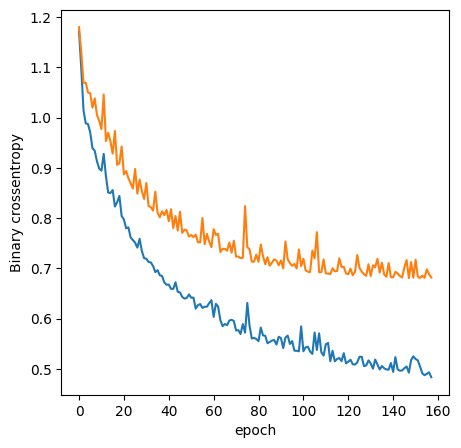

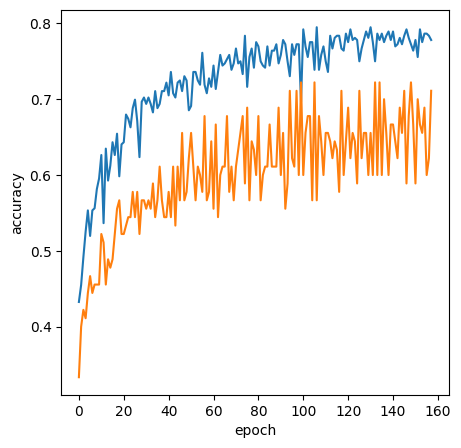

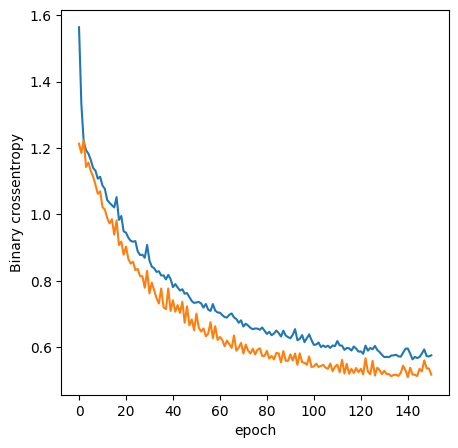

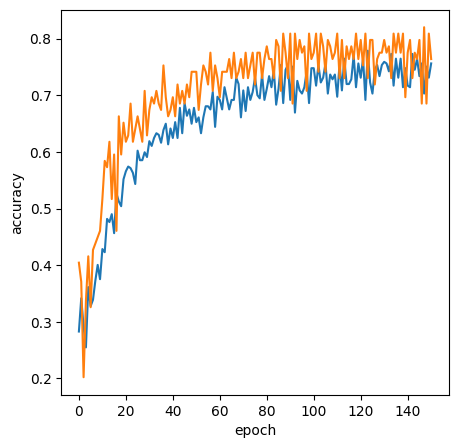

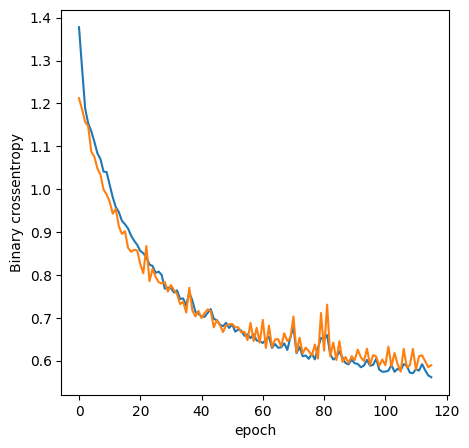

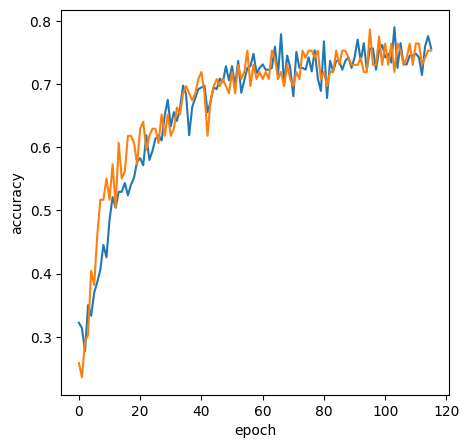

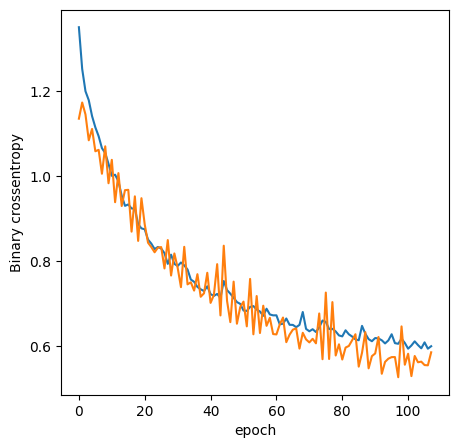

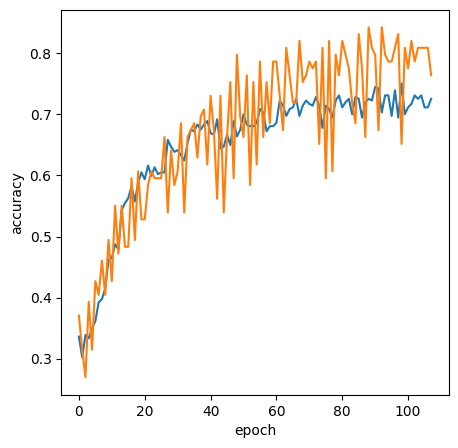

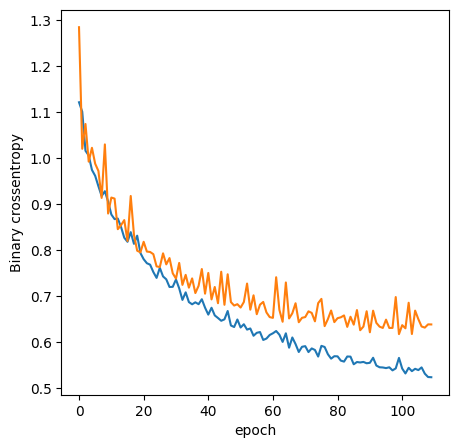

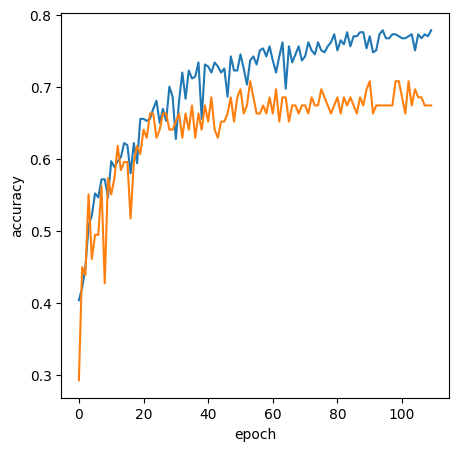

In [32]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(x_train)),y_train):
    training_data_x = x_train[train_index]
    training_data_y = y_train[train_index]
    validation_data_x = x_train[val_index]
    validation_data_y = y_train[val_index]
    
    # Get new model from above
    model_mtl = get_model()
    # COMPILE NEW MODEL
    # learning rate from above tuner results
    model_mtl.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00025026247369061555),
                  loss="categorical_crossentropy", # categorical cross-entropy loss function for multi-task model
                  metrics=['accuracy'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_loss', verbose=1, 
                                                    save_best_only=True, mode='min')
    
    callbacks_list = [checkpoint,
                      EarlyStopping(patience=10, restore_best_weights=True),
                      History()]

    # Train the model
    history_transfer = model_mtl.fit(training_data_x,
                                 training_data_y,
                                 validation_data=(validation_data_x, validation_data_y),
                                 callbacks=callbacks_list,
                                 epochs=300) 
    
    # plot history
    plot_loss(history_transfer.history)
    plot_acc(history_transfer.history)
    
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model_mtl.load_weights(save_dir+get_model_name(fold_var))

    results = model_mtl.evaluate(validation_data_x, validation_data_y)
    results = dict(zip(model_mtl.metrics_names,results))

    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])

    fold_var += 1

In [33]:
VALIDATION_ACCURACY

[0.67777777, 0.7752809, 0.752809, 0.83146065, 0.7078652]

In [34]:
VALIDATION_LOSS

[0.6805759151776631,
 0.509422700056869,
 0.5743814325064756,
 0.526935144086902,
 0.6170563028099831]

In [35]:
# load best performing model
best_model = keras.models.load_model("kFoldCV_saved_models/model_4.h5")

In [36]:
# Evaluate the best model.
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

112/112 [==============================] - 0s 3ms/sample - loss: 0.6709 - acc: 0.7232
[test loss, test accuracy]: [0.6708845666476658, 0.72321427]


In [37]:
best_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_main (InputLayer)         [(None, 200, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 128)     10368       input_main[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     163968      conv1d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 200, 128)     0           conv1d_1[0][0]                   
                                                                 conv1d[0][0]               

In [38]:
# Re-enable training for the last convolutional layer for fine tuning to the multi-task problem
best_model.get_layer('conv1d_7').trainable = True

Train on 356 samples, validate on 90 samples
Epoch 1/300
352/356 [============================>.] - ETA: 0s - loss: 0.6870 - acc: 0.6818
Epoch 00001: val_loss improved from inf to 0.69655, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 3s 7ms/sample - loss: 0.6897 - acc: 0.6798 - val_loss: 0.6965 - val_acc: 0.7000
Epoch 2/300
352/356 [============================>.] - ETA: 0s - loss: 0.5981 - acc: 0.7330
Epoch 00002: val_loss did not improve from 0.69655
356/356 [==============================] - 1s 4ms/sample - loss: 0.5982 - acc: 0.7331 - val_loss: 0.7218 - val_acc: 0.6667
Epoch 3/300
352/356 [============================>.] - ETA: 0s - loss: 0.5643 - acc: 0.7472
Epoch 00003: val_loss improved from 0.69655 to 0.68648, saving model to ./kFoldCV_saved_models/model_1.h5
356/356 [==============================] - 2s 4ms/sample - loss: 0.5677 - acc: 0.7472 - val_loss: 0.6865 - val_acc: 0.7000
Epoch 4/300
352/356 [============================>.

Epoch 11/300
352/357 [============================>.] - ETA: 0s - loss: 0.4184 - acc: 0.8608
Epoch 00011: val_loss did not improve from 0.39423
357/357 [==============================] - 1s 4ms/sample - loss: 0.4193 - acc: 0.8627 - val_loss: 0.4514 - val_acc: 0.7416
Epoch 12/300
352/357 [============================>.] - ETA: 0s - loss: 0.4795 - acc: 0.7926
Epoch 00012: val_loss did not improve from 0.39423
357/357 [==============================] - 1s 4ms/sample - loss: 0.4815 - acc: 0.7899 - val_loss: 0.4831 - val_acc: 0.6966
Epoch 13/300
352/357 [============================>.] - ETA: 0s - loss: 0.4367 - acc: 0.8438
Epoch 00013: val_loss did not improve from 0.39423
357/357 [==============================] - 2s 4ms/sample - loss: 0.4358 - acc: 0.8459 - val_loss: 0.4371 - val_acc: 0.8539
Epoch 14/300
352/357 [============================>.] - ETA: 0s - loss: 0.4518 - acc: 0.7869
Epoch 00014: val_loss did not improve from 0.39423
89/89 [==============================] - 0s 2ms/sample 

Epoch 10/300
352/357 [============================>.] - ETA: 0s - loss: 0.3648 - acc: 0.8920
Epoch 00010: val_loss did not improve from 0.36885
357/357 [==============================] - 2s 4ms/sample - loss: 0.3643 - acc: 0.8936 - val_loss: 0.4158 - val_acc: 0.8539
Epoch 11/300
352/357 [============================>.] - ETA: 0s - loss: 0.3759 - acc: 0.8778
Epoch 00011: val_loss improved from 0.36885 to 0.34118, saving model to ./kFoldCV_saved_models/model_4.h5
357/357 [==============================] - 1s 4ms/sample - loss: 0.3764 - acc: 0.8739 - val_loss: 0.3412 - val_acc: 0.8764
Epoch 12/300
352/357 [============================>.] - ETA: 0s - loss: 0.3832 - acc: 0.8466
Epoch 00012: val_loss did not improve from 0.34118
357/357 [==============================] - 2s 5ms/sample - loss: 0.3880 - acc: 0.8431 - val_loss: 0.4133 - val_acc: 0.8315
Epoch 13/300
352/357 [============================>.] - ETA: 0s - loss: 0.3793 - acc: 0.8722
Epoch 00013: val_loss did not improve from 0.34118


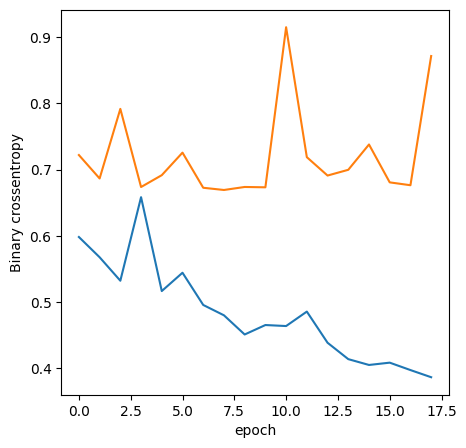

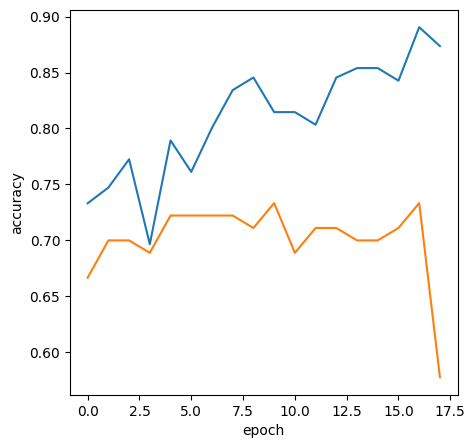

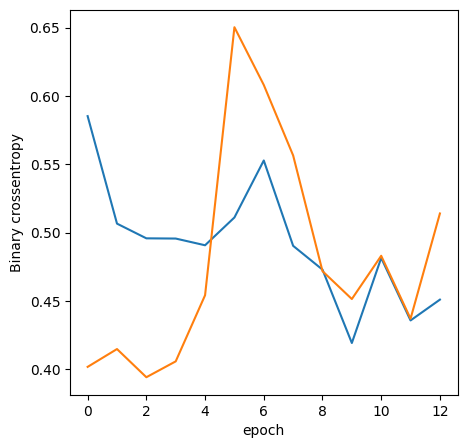

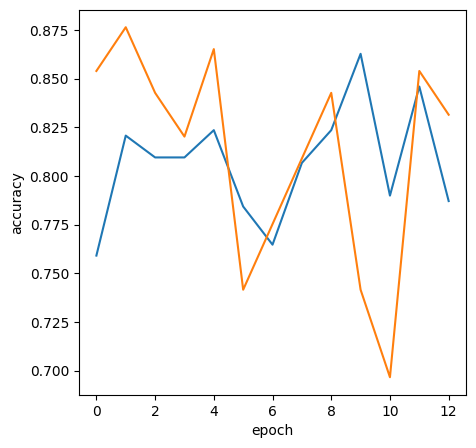

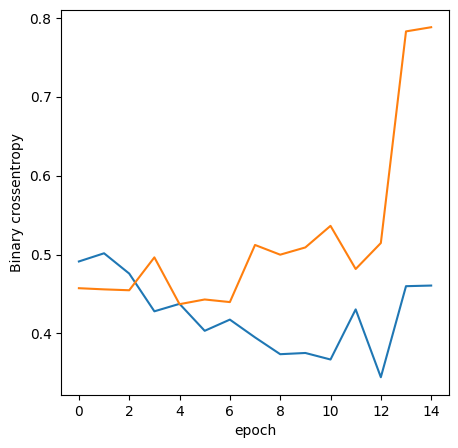

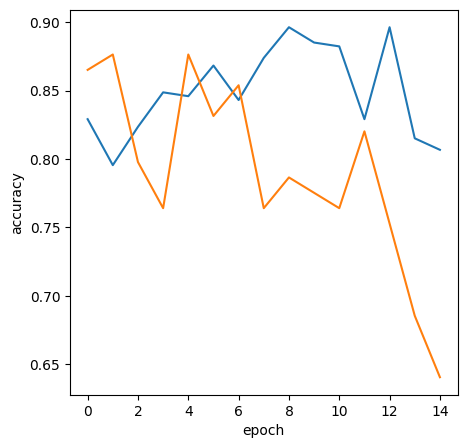

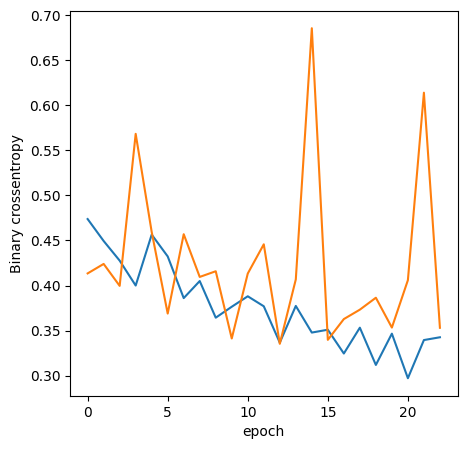

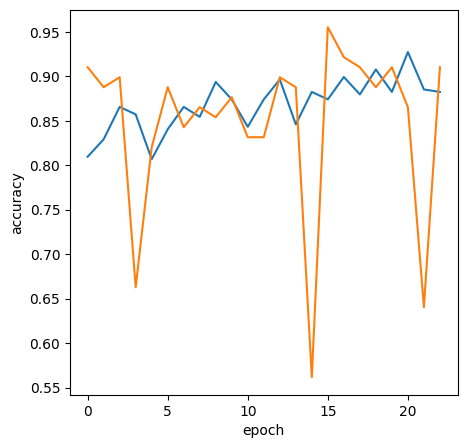

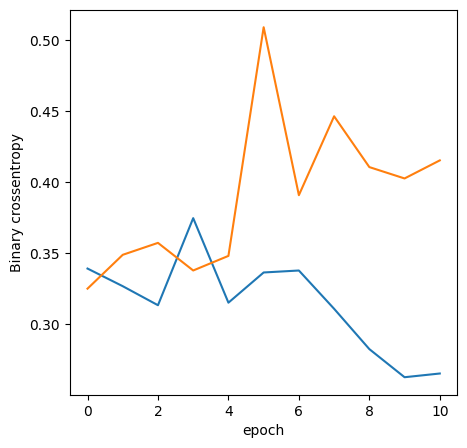

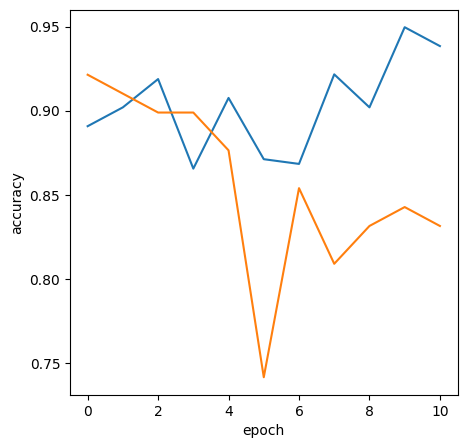

In [39]:
# and finally, retrain
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = './kFoldCV_saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(x_train)),y_train):
    training_data_x = x_train[train_index]
    training_data_y = y_train[train_index]
    validation_data_x = x_train[val_index]
    validation_data_y = y_train[val_index]
    
    # CREATE NEW MODEL
    #transferred_model = Model(best_model.inputs, best_model.layers[-3].output)
    #for layer in transferred_model.layers:
    #    layer.trainable = False
    #x = transferred_model.output
    #x = kl.Dense(32)(x)
    #output = kl.Dense(units=len(cells), activation="sigmoid")(x)
    model_mtl = best_model
    # COMPILE NEW MODEL
    # learning rate from above tuner results
    model_mtl.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0004926815023151231),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_loss', verbose=1, 
                                                    save_best_only=True, mode='min')
    
    callbacks_list = [checkpoint,
                      EarlyStopping(patience=10, restore_best_weights=True),
                      History()]

    # Train the model
    history_transfer = model_mtl.fit(training_data_x,
                                 training_data_y,
                                 validation_data=(validation_data_x, validation_data_y),
                                 callbacks=callbacks_list,
                                 epochs=300) 
    
    # plot history
    plot_loss(history_transfer.history)
    plot_acc(history_transfer.history)
    
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model_mtl.load_weights(save_dir+get_model_name(fold_var))

    results = model_mtl.evaluate(validation_data_x, validation_data_y)
    results = dict(zip(model_mtl.metrics_names,results))

    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])

    fold_var += 1

In [40]:
VALIDATION_ACCURACY

[0.7222222, 0.8426966, 0.8764045, 0.8988764, 0.92134833]

In [41]:
VALIDATION_LOSS

[0.6691214680671692,
 0.3942332197441144,
 0.4370861843730626,
 0.33526643809307827,
 0.3250042598568991]

In [42]:
# load best performing model
best_index = VALIDATION_LOSS.index(min(VALIDATION_LOSS)) + 1
print("K-fold with lowest loss: {}".format(best_index))
best_model = keras.models.load_model(save_dir + "model_" + str(best_index) + ".h5")

K-fold with lowest loss: 5


In [43]:
# save weights to HDF5
best_model.save_weights("model/tRNet_multitask_modelWeights.h5")
# save architecture to json
model_json = best_model.to_json()
with open("model/tRNet_multitask_modelJSON.json", "w") as json_file:
    json_file.write(model_json)
    
# save whole model
best_model.save("model/tRNet_multitask_model.h5")

In [44]:
# Evaluate the best model.
min_loss = np.NAN
for model in ["kFoldCV_saved_models/model_1.h5", "kFoldCV_saved_models/model_2.h5", "kFoldCV_saved_models/model_3.h5", "kFoldCV_saved_models/model_4.h5", "kFoldCV_saved_models/model_5.h5"]:
    cur_model = keras.models.load_model(model)
    eval_result = cur_model.evaluate(x_test, y_test)
    if np.isnan(min_loss):
        min_loss = eval_result[0]
        best_model = cur_model
    elif eval_result[0] < min_loss:
        best_model = cur_model
        best_model_name = model
        min_loss = eval_result[0]
    print(str(model.split("/")[1]) + "[test loss, test accuracy]:", eval_result)

print("\nBest model based on evaluation: {}".format(best_model_name))

112/112 [==============================] - 0s 4ms/sample - loss: 0.6354 - acc: 0.7500
model_1.h5[test loss, test accuracy]: [0.6354115690503802, 0.75]
112/112 [==============================] - 0s 4ms/sample - loss: 0.6154 - acc: 0.7411
model_2.h5[test loss, test accuracy]: [0.6153628315244403, 0.7410714]
112/112 [==============================] - 0s 4ms/sample - loss: 0.6348 - acc: 0.7500
model_3.h5[test loss, test accuracy]: [0.6347797768456596, 0.75]
112/112 [==============================] - 0s 4ms/sample - loss: 0.6463 - acc: 0.7143
model_4.h5[test loss, test accuracy]: [0.6463193297386169, 0.71428573]
112/112 [==============================] - 0s 4ms/sample - loss: 0.5852 - acc: 0.7500
model_5.h5[test loss, test accuracy]: [0.5852216567311969, 0.75]

Best model based on evaluation: kFoldCV_saved_models/model_5.h5


In [13]:
from tensorflow import keras
from tensorflow.keras.models import model_from_json
keras_model_weights = "model/tRNet_multitask_modelWeights.h5"
keras_model_json = "model/tRNet_multitask_modelJSON.json"
best_model = model_from_json(open(keras_model_json).read())
best_model.load_weights(keras_model_weights)

In [14]:
preds_transfer_val = best_model.predict(x_test)

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
roc_auc_score(y_test, preds_transfer_val)

0.8929375413379774

In [26]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(tasks)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds_transfer_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# save fpr and tpr 
with open("model/tRNet_multiclass_FPR_TPR.csv", "w") as out:
    out.write("fpr\ttpr\ttask\n")
    for task in fpr:
        for item in zip(fpr[task], tpr[task]):
            out.write(str(item[0])+ "\t" + str(item[1]) + "\t" + str(task) + "\n")
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds_transfer_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/drew/anaconda3/envs/deeplift-modisco/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':


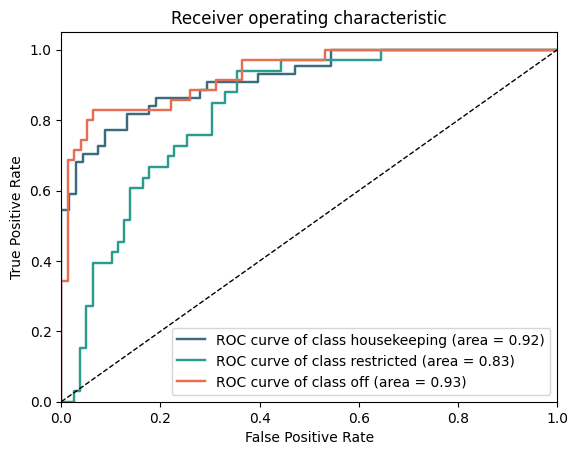

In [48]:
# plot roc curves for multilabel output
from itertools import cycle

lw = 1.75

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(tasks))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(tasks)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(tasks)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=2)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=2)

colors = cycle(["#3A6B7E", "#2a9d8f", "#e76f51"])
for i, color in zip(range(len(tasks)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(tasks[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("model/tRNet_multiclass_multiROC.pdf")
plt.show()